In [20]:
import torch
import numpy as np
#这个是一组输入温度计温度和表测值之间的数据，想找到表测值和实际温度的函数关系
#注意： 先假设线性函数关系 t_c = w*t_u + b
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0] 
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4] 
t_c = torch.tensor(t_c) 
t_u = torch.tensor(t_u) 
print(t_c.shape)

torch.Size([11])


In [21]:
# 1. 定义模型
def model(t_u,w,b):
    return w *t_u + b

#2. 定义损失函数，这里调用mean 是为了计算出来保证是标量
def loss_fn(t_p,t_c):
    squared_diffs  = (t_p - t_c )**2
    return squared_diffs.mean()

w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b) 
print(t_p)
loss = loss_fn(t_p,t_c)
print(loss)

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])
tensor(1763.8848)


In [22]:
#3. 计算损失函数分别对w ,b 的倒数，并且更新w ,b
delta = 0.1
loss_rate_w = (loss_fn(model(t_u, w+delta, b),t_c) - loss_fn(model(t_u, w-delta, b),t_c))/(2.0 * delta )
loss_rate_b = (loss_fn(model(t_u, w, b+delta),t_c) - loss_fn(model(t_u, w, b-delta),t_c))/(2.0 * delta )

learning_rate = 1e-2
w = w - learning_rate*loss_rate_w
b = b - learning_rate*loss_rate_b
print(w,b)

tensor(-44.1730) tensor(-0.8260)


In [23]:
#4. 采用链式法则来计算倒数 dloss/dw = dloss/t_p* t_p/dw
def dloss_fn(t_p, t_c):
    dsq_diff = 2 * (t_p - t_c )/t_p.size(0)
    #print("t_p.size(0) :",t_p.size(0)) -> 打印出来这个值是11 
    return dsq_diff
#   t_c = w*t_u + b
def dmodel_dw(t_u, w, b): 
    return t_u 

def dmodel_db(t_u, w, b): 
    return 1.0 

def grad_fn(t_u, t_c, t_p, w, b): 
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()]) 

In [24]:
# 5. 定义一次训练的流程
def training_loop(n_epochs, learning_rate, params, t_u, t_c): 
    for epoch in range(1, n_epochs + 1): 
        w, b = params 
        t_p = model(t_u, w, b) #正向传播
        loss  = loss_fn(t_p,t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)# 反向梯度计算
        
        params = params - learning_rate*grad
        print('Epoch %d, Loss %f' % (epoch, float(loss))) 
        print("  params : " ,params)
        print("  grad : " ,grad)

    return params 
       

In [25]:
# 6. 开始训练。 
    
training_loop( 
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
  params :  tensor([ 0.5483, -0.0083])
  grad :  tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
  params :  tensor([ 0.3623, -0.0118])
  grad :  tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
  params :  tensor([ 0.2858, -0.0135])
  grad :  tensor([765.4666,  16.5122])
Epoch 4, Loss 37.552845
  params :  tensor([ 0.2543, -0.0143])
  grad :  tensor([315.0790,   8.5787])
Epoch 5, Loss 30.540283
  params :  tensor([ 0.2413, -0.0149])
  grad :  tensor([129.6733,   5.3127])
Epoch 6, Loss 29.351154
  params :  tensor([ 0.2360, -0.0153])
  grad :  tensor([53.3495,  3.9682])
Epoch 7, Loss 29.148884
  params :  tensor([ 0.2338, -0.0156])
  grad :  tensor([21.9304,  3.4148])
Epoch 8, Loss 29.113848
  params :  tensor([ 0.2329, -0.0159])
  grad :  tensor([8.9964, 3.1869])
Epoch 9, Loss 29.107145
  params :  tensor([ 0.2325, -0.0162])
  grad :  tensor([3.6721, 3.0930])
Epoch 10, Loss 29.105247
  params :  tensor([ 0.2324, -0.0166])
  grad :  tensor([1.480

tensor([ 0.2327, -0.0438])

In [26]:
# 由于 t_p = w* t_u + b ,并且我们可以发现 对于grad 的权重比例 W的梯度是 b的梯度下降的50 倍，这表示w 和 b 不在同一比例空间之中。
# 我们可以对t_u 进行归一化输入，来降低w 所占的梯度比例。（如果学习参数有明显的比例区别的话，参数输入会对这个参数十分敏感，对其他的不敏感）
#因为现在是线性训练，W可以乘以系数成回去，但是b 基本保持不变，可以理解为下方行数训练而来。
#t_p = w*（0.1*t_u）+b
params = torch.tensor([1.0, 0.0])
t_un = 0.1 * t_u
training_loop( 
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c)

Epoch 1, Loss 80.364342
  params :  tensor([1.7761, 0.1064])
  grad :  tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
  params :  tensor([2.0848, 0.1303])
  grad :  tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
  params :  tensor([2.2094, 0.1217])
  grad :  tensor([-12.4631,   0.8587])
Epoch 4, Loss 29.756193
  params :  tensor([2.2616, 0.1004])
  grad :  tensor([-5.2218,  2.1327])
Epoch 5, Loss 29.507153
  params :  tensor([2.2853, 0.0740])
  grad :  tensor([-2.3715,  2.6310])
Epoch 6, Loss 29.392456
  params :  tensor([2.2978, 0.0458])
  grad :  tensor([-1.2492,  2.8241])
Epoch 7, Loss 29.298828
  params :  tensor([2.3059, 0.0168])
  grad :  tensor([-0.8071,  2.8970])
Epoch 8, Loss 29.208717
  params :  tensor([ 2.3122, -0.0124])
  grad :  tensor([-0.6325,  2.9227])
Epoch 9, Loss 29.119415
  params :  tensor([ 2.3178, -0.0417])
  grad :  tensor([-0.5633,  2.9298])
Epoch 10, Loss 29.030489
  params :  tensor([ 2.3232, -0.0710])
  grad :  tensor([-0.5355,  2.9295])
Epoch 1

  params :  tensor([ 2.7195, -2.3137])
  grad :  tensor([-0.4506,  2.5510])
Epoch 93, Loss 22.611717
  params :  tensor([ 2.7240, -2.3392])
  grad :  tensor([-0.4499,  2.5466])
Epoch 94, Loss 22.544899
  params :  tensor([ 2.7285, -2.3646])
  grad :  tensor([-0.4491,  2.5423])
Epoch 95, Loss 22.478306
  params :  tensor([ 2.7330, -2.3900])
  grad :  tensor([-0.4483,  2.5380])
Epoch 96, Loss 22.411934
  params :  tensor([ 2.7374, -2.4153])
  grad :  tensor([-0.4476,  2.5337])
Epoch 97, Loss 22.345793
  params :  tensor([ 2.7419, -2.4406])
  grad :  tensor([-0.4468,  2.5294])
Epoch 98, Loss 22.279875
  params :  tensor([ 2.7464, -2.4658])
  grad :  tensor([-0.4461,  2.5251])
Epoch 99, Loss 22.214186
  params :  tensor([ 2.7508, -2.4910])
  grad :  tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
  params :  tensor([ 2.7553, -2.5162])
  grad :  tensor([-0.4446,  2.5165])
Epoch 101, Loss 22.083464
  params :  tensor([ 2.7597, -2.5413])
  grad :  tensor([-0.4438,  2.5122])
Epoch 102, Lo

  params :  tensor([ 3.1824, -4.9341])
  grad :  tensor([-0.3719,  2.1051])
Epoch 206, Loss 16.331776
  params :  tensor([ 3.1861, -4.9551])
  grad :  tensor([-0.3712,  2.1015])
Epoch 207, Loss 16.286276
  params :  tensor([ 3.1898, -4.9760])
  grad :  tensor([-0.3706,  2.0979])
Epoch 208, Loss 16.240929
  params :  tensor([ 3.1935, -4.9970])
  grad :  tensor([-0.3700,  2.0944])
Epoch 209, Loss 16.195732
  params :  tensor([ 3.1972, -5.0179])
  grad :  tensor([-0.3694,  2.0908])
Epoch 210, Loss 16.150694
  params :  tensor([ 3.2009, -5.0388])
  grad :  tensor([-0.3687,  2.0873])
Epoch 211, Loss 16.105806
  params :  tensor([ 3.2046, -5.0596])
  grad :  tensor([-0.3681,  2.0837])
Epoch 212, Loss 16.061073
  params :  tensor([ 3.2082, -5.0804])
  grad :  tensor([-0.3675,  2.0802])
Epoch 213, Loss 16.016487
  params :  tensor([ 3.2119, -5.1012])
  grad :  tensor([-0.3668,  2.0766])
Epoch 214, Loss 15.972058
  params :  tensor([ 3.2156, -5.1219])
  grad :  tensor([-0.3662,  2.0731])
Epoch 

  params :  tensor([ 3.7254, -8.0077])
  grad :  tensor([-0.2795,  1.5820])
Epoch 374, Loss 10.498409
  params :  tensor([ 3.7282, -8.0235])
  grad :  tensor([-0.2790,  1.5794])
Epoch 375, Loss 10.472707
  params :  tensor([ 3.7309, -8.0393])
  grad :  tensor([-0.2785,  1.5767])
Epoch 376, Loss 10.447093
  params :  tensor([ 3.7337, -8.0550])
  grad :  tensor([-0.2780,  1.5740])
Epoch 377, Loss 10.421569
  params :  tensor([ 3.7365, -8.0707])
  grad :  tensor([-0.2776,  1.5713])
Epoch 378, Loss 10.396132
  params :  tensor([ 3.7393, -8.0864])
  grad :  tensor([-0.2771,  1.5686])
Epoch 379, Loss 10.370779
  params :  tensor([ 3.7420, -8.1021])
  grad :  tensor([-0.2766,  1.5660])
Epoch 380, Loss 10.345510
  params :  tensor([ 3.7448, -8.1177])
  grad :  tensor([-0.2762,  1.5633])
Epoch 381, Loss 10.320328
  params :  tensor([ 3.7476, -8.1333])
  grad :  tensor([-0.2757,  1.5607])
Epoch 382, Loss 10.295234
  params :  tensor([ 3.7503, -8.1489])
  grad :  tensor([-0.2752,  1.5580])
Epoch 

  params :  tensor([ 3.9985, -9.5541])
  grad :  tensor([-0.2330,  1.3189])
Epoch 481, Loss 8.189310
  params :  tensor([ 4.0009, -9.5673])
  grad :  tensor([-0.2326,  1.3166])
Epoch 482, Loss 8.171452
  params :  tensor([ 4.0032, -9.5805])
  grad :  tensor([-0.2322,  1.3144])
Epoch 483, Loss 8.153647
  params :  tensor([ 4.0055, -9.5936])
  grad :  tensor([-0.2318,  1.3122])
Epoch 484, Loss 8.135906
  params :  tensor([ 4.0078, -9.6067])
  grad :  tensor([-0.2314,  1.3100])
Epoch 485, Loss 8.118226
  params :  tensor([ 4.0101, -9.6198])
  grad :  tensor([-0.2310,  1.3077])
Epoch 486, Loss 8.100607
  params :  tensor([ 4.0124, -9.6328])
  grad :  tensor([-0.2306,  1.3055])
Epoch 487, Loss 8.083045
  params :  tensor([ 4.0147, -9.6458])
  grad :  tensor([-0.2302,  1.3033])
Epoch 488, Loss 8.065548
  params :  tensor([ 4.0170, -9.6589])
  grad :  tensor([-0.2298,  1.3011])
Epoch 489, Loss 8.048104
  params :  tensor([ 4.0193, -9.6718])
  grad :  tensor([-0.2295,  1.2989])
Epoch 490, Loss

Epoch 600, Loss 6.438284
  params :  tensor([  4.2512, -10.9846])
  grad :  tensor([-0.1900,  1.0755])
Epoch 601, Loss 6.426368
  params :  tensor([  4.2531, -10.9953])
  grad :  tensor([-0.1897,  1.0737])
Epoch 602, Loss 6.414490
  params :  tensor([  4.2550, -11.0060])
  grad :  tensor([-0.1893,  1.0718])
Epoch 603, Loss 6.402653
  params :  tensor([  4.2569, -11.0167])
  grad :  tensor([-0.1890,  1.0700])
Epoch 604, Loss 6.390859
  params :  tensor([  4.2588, -11.0274])
  grad :  tensor([-0.1887,  1.0682])
Epoch 605, Loss 6.379103
  params :  tensor([  4.2607, -11.0381])
  grad :  tensor([-0.1884,  1.0664])
Epoch 606, Loss 6.367385
  params :  tensor([  4.2626, -11.0487])
  grad :  tensor([-0.1880,  1.0646])
Epoch 607, Loss 6.355706
  params :  tensor([  4.2644, -11.0594])
  grad :  tensor([-0.1877,  1.0628])
Epoch 608, Loss 6.344070
  params :  tensor([  4.2663, -11.0700])
  grad :  tensor([-0.1874,  1.0609])
Epoch 609, Loss 6.332472
  params :  tensor([  4.2682, -11.0806])
  grad 

  params :  tensor([  4.4495, -12.1070])
  grad :  tensor([-0.1562,  0.8845])
Epoch 716, Loss 5.293994
  params :  tensor([  4.4511, -12.1159])
  grad :  tensor([-0.1560,  0.8830])
Epoch 717, Loss 5.285964
  params :  tensor([  4.4526, -12.1247])
  grad :  tensor([-0.1557,  0.8815])
Epoch 718, Loss 5.277958
  params :  tensor([  4.4542, -12.1335])
  grad :  tensor([-0.1555,  0.8800])
Epoch 719, Loss 5.269979
  params :  tensor([  4.4557, -12.1423])
  grad :  tensor([-0.1552,  0.8785])
Epoch 720, Loss 5.262027
  params :  tensor([  4.4573, -12.1510])
  grad :  tensor([-0.1549,  0.8770])
Epoch 721, Loss 5.254103
  params :  tensor([  4.4588, -12.1598])
  grad :  tensor([-0.1547,  0.8755])
Epoch 722, Loss 5.246205
  params :  tensor([  4.4604, -12.1685])
  grad :  tensor([-0.1544,  0.8740])
Epoch 723, Loss 5.238335
  params :  tensor([  4.4619, -12.1773])
  grad :  tensor([-0.1541,  0.8725])
Epoch 724, Loss 5.230492
  params :  tensor([  4.4635, -12.1860])
  grad :  tensor([-0.1539,  0.87

  params :  tensor([  4.6177, -13.0591])
  grad :  tensor([-0.1276,  0.7225])
Epoch 835, Loss 4.506505
  params :  tensor([  4.6190, -13.0663])
  grad :  tensor([-0.1274,  0.7212])
Epoch 836, Loss 4.501141
  params :  tensor([  4.6203, -13.0735])
  grad :  tensor([-0.1272,  0.7200])
Epoch 837, Loss 4.495801
  params :  tensor([  4.6215, -13.0807])
  grad :  tensor([-0.1270,  0.7188])
Epoch 838, Loss 4.490475
  params :  tensor([  4.6228, -13.0879])
  grad :  tensor([-0.1268,  0.7176])
Epoch 839, Loss 4.485169
  params :  tensor([  4.6241, -13.0950])
  grad :  tensor([-0.1266,  0.7163])
Epoch 840, Loss 4.479884
  params :  tensor([  4.6253, -13.1022])
  grad :  tensor([-0.1263,  0.7151])
Epoch 841, Loss 4.474613
  params :  tensor([  4.6266, -13.1093])
  grad :  tensor([-0.1261,  0.7139])
Epoch 842, Loss 4.469364
  params :  tensor([  4.6278, -13.1165])
  grad :  tensor([-0.1259,  0.7127])
Epoch 843, Loss 4.464130
  params :  tensor([  4.6291, -13.1236])
  grad :  tensor([-0.1257,  0.71

  grad :  tensor([-0.1046,  0.5921])
Epoch 952, Loss 3.988261
  params :  tensor([  4.7540, -13.8309])
  grad :  tensor([-0.1044,  0.5911])
Epoch 953, Loss 3.984660
  params :  tensor([  4.7551, -13.8368])
  grad :  tensor([-0.1042,  0.5901])
Epoch 954, Loss 3.981073
  params :  tensor([  4.7561, -13.8427])
  grad :  tensor([-0.1041,  0.5891])
Epoch 955, Loss 3.977496
  params :  tensor([  4.7572, -13.8486])
  grad :  tensor([-0.1039,  0.5881])
Epoch 956, Loss 3.973931
  params :  tensor([  4.7582, -13.8544])
  grad :  tensor([-0.1037,  0.5871])
Epoch 957, Loss 3.970381
  params :  tensor([  4.7592, -13.8603])
  grad :  tensor([-0.1035,  0.5861])
Epoch 958, Loss 3.966841
  params :  tensor([  4.7603, -13.8661])
  grad :  tensor([-0.1034,  0.5851])
Epoch 959, Loss 3.963313
  params :  tensor([  4.7613, -13.8720])
  grad :  tensor([-0.1032,  0.5841])
Epoch 960, Loss 3.959796
  params :  tensor([  4.7623, -13.8778])
  grad :  tensor([-0.1030,  0.5831])
Epoch 961, Loss 3.956295
  params : 

Epoch 1071, Loss 3.635302
  params :  tensor([  4.8665, -14.4672])
  grad :  tensor([-0.0853,  0.4829])
Epoch 1072, Loss 3.632902
  params :  tensor([  4.8673, -14.4720])
  grad :  tensor([-0.0851,  0.4820])
Epoch 1073, Loss 3.630508
  params :  tensor([  4.8682, -14.4768])
  grad :  tensor([-0.0850,  0.4812])
Epoch 1074, Loss 3.628119
  params :  tensor([  4.8690, -14.4816])
  grad :  tensor([-0.0849,  0.4804])
Epoch 1075, Loss 3.625741
  params :  tensor([  4.8698, -14.4864])
  grad :  tensor([-0.0847,  0.4796])
Epoch 1076, Loss 3.623374
  params :  tensor([  4.8707, -14.4912])
  grad :  tensor([-0.0846,  0.4788])
Epoch 1077, Loss 3.621010
  params :  tensor([  4.8715, -14.4960])
  grad :  tensor([-0.0844,  0.4780])
Epoch 1078, Loss 3.618659
  params :  tensor([  4.8724, -14.5008])
  grad :  tensor([-0.0843,  0.4771])
Epoch 1079, Loss 3.616311
  params :  tensor([  4.8732, -14.5055])
  grad :  tensor([-0.0841,  0.4763])
Epoch 1080, Loss 3.613973
  params :  tensor([  4.8741, -14.5103

Epoch 1251, Loss 3.311353
  params :  tensor([  4.9986, -15.2153])
  grad :  tensor([-0.0628,  0.3556])
Epoch 1252, Loss 3.310053
  params :  tensor([  4.9992, -15.2189])
  grad :  tensor([-0.0627,  0.3550])
Epoch 1253, Loss 3.308756
  params :  tensor([  4.9999, -15.2224])
  grad :  tensor([-0.0626,  0.3543])
Epoch 1254, Loss 3.307463
  params :  tensor([  5.0005, -15.2259])
  grad :  tensor([-0.0625,  0.3537])
Epoch 1255, Loss 3.306170
  params :  tensor([  5.0011, -15.2295])
  grad :  tensor([-0.0624,  0.3531])
Epoch 1256, Loss 3.304887
  params :  tensor([  5.0017, -15.2330])
  grad :  tensor([-0.0623,  0.3525])
Epoch 1257, Loss 3.303605
  params :  tensor([  5.0024, -15.2365])
  grad :  tensor([-0.0622,  0.3519])
Epoch 1258, Loss 3.302329
  params :  tensor([  5.0030, -15.2400])
  grad :  tensor([-0.0620,  0.3514])
Epoch 1259, Loss 3.301057
  params :  tensor([  5.0036, -15.2435])
  grad :  tensor([-0.0620,  0.3508])
Epoch 1260, Loss 3.299791
  params :  tensor([  5.0042, -15.2470

  grad :  tensor([-0.0529,  0.2995])
Epoch 1353, Loss 3.198897
  params :  tensor([  5.0574, -15.5480])
  grad :  tensor([-0.0528,  0.2989])
Epoch 1354, Loss 3.197976
  params :  tensor([  5.0579, -15.5510])
  grad :  tensor([-0.0527,  0.2984])
Epoch 1355, Loss 3.197060
  params :  tensor([  5.0584, -15.5539])
  grad :  tensor([-0.0526,  0.2979])
Epoch 1356, Loss 3.196143
  params :  tensor([  5.0590, -15.5569])
  grad :  tensor([-0.0525,  0.2974])
Epoch 1357, Loss 3.195231
  params :  tensor([  5.0595, -15.5599])
  grad :  tensor([-0.0524,  0.2969])
Epoch 1358, Loss 3.194324
  params :  tensor([  5.0600, -15.5629])
  grad :  tensor([-0.0524,  0.2964])
Epoch 1359, Loss 3.193420
  params :  tensor([  5.0605, -15.5658])
  grad :  tensor([-0.0523,  0.2959])
Epoch 1360, Loss 3.192517
  params :  tensor([  5.0610, -15.5688])
  grad :  tensor([-0.0522,  0.2954])
Epoch 1361, Loss 3.191616
  params :  tensor([  5.0616, -15.5717])
  grad :  tensor([-0.0521,  0.2949])
Epoch 1362, Loss 3.190720
 

  grad :  tensor([-0.0459,  0.2600])
Epoch 1436, Loss 3.132194
  params :  tensor([  5.0982, -15.7792])
  grad :  tensor([-0.0459,  0.2596])
Epoch 1437, Loss 3.131500
  params :  tensor([  5.0987, -15.7818])
  grad :  tensor([-0.0458,  0.2592])
Epoch 1438, Loss 3.130810
  params :  tensor([  5.0991, -15.7844])
  grad :  tensor([-0.0457,  0.2587])
Epoch 1439, Loss 3.130119
  params :  tensor([  5.0996, -15.7870])
  grad :  tensor([-0.0456,  0.2583])
Epoch 1440, Loss 3.129432
  params :  tensor([  5.1000, -15.7895])
  grad :  tensor([-0.0455,  0.2578])
Epoch 1441, Loss 3.128746
  params :  tensor([  5.1005, -15.7921])
  grad :  tensor([-0.0455,  0.2574])
Epoch 1442, Loss 3.128064
  params :  tensor([  5.1010, -15.7947])
  grad :  tensor([-0.0454,  0.2570])
Epoch 1443, Loss 3.127382
  params :  tensor([  5.1014, -15.7973])
  grad :  tensor([-0.0453,  0.2565])
Epoch 1444, Loss 3.126705
  params :  tensor([  5.1019, -15.7998])
  grad :  tensor([-0.0453,  0.2561])
Epoch 1445, Loss 3.126030
 

Epoch 1557, Loss 3.063199
  params :  tensor([  5.1483, -16.0629])
  grad :  tensor([-0.0373,  0.2113])
Epoch 1558, Loss 3.062738
  params :  tensor([  5.1487, -16.0650])
  grad :  tensor([-0.0373,  0.2110])
Epoch 1559, Loss 3.062280
  params :  tensor([  5.1491, -16.0671])
  grad :  tensor([-0.0372,  0.2106])
Epoch 1560, Loss 3.061822
  params :  tensor([  5.1494, -16.0692])
  grad :  tensor([-0.0371,  0.2103])
Epoch 1561, Loss 3.061367
  params :  tensor([  5.1498, -16.0713])
  grad :  tensor([-0.0371,  0.2099])
Epoch 1562, Loss 3.060913
  params :  tensor([  5.1502, -16.0734])
  grad :  tensor([-0.0370,  0.2095])
Epoch 1563, Loss 3.060462
  params :  tensor([  5.1506, -16.0755])
  grad :  tensor([-0.0370,  0.2092])
Epoch 1564, Loss 3.060011
  params :  tensor([  5.1509, -16.0776])
  grad :  tensor([-0.0369,  0.2088])
Epoch 1565, Loss 3.059561
  params :  tensor([  5.1513, -16.0796])
  grad :  tensor([-0.0368,  0.2085])
Epoch 1566, Loss 3.059114
  params :  tensor([  5.1517, -16.0817

Epoch 1675, Loss 3.018395
  params :  tensor([  5.1882, -16.2886])
  grad :  tensor([-0.0305,  0.1729])
Epoch 1676, Loss 3.018089
  params :  tensor([  5.1885, -16.2904])
  grad :  tensor([-0.0305,  0.1726])
Epoch 1677, Loss 3.017780
  params :  tensor([  5.1888, -16.2921])
  grad :  tensor([-0.0304,  0.1723])
Epoch 1678, Loss 3.017475
  params :  tensor([  5.1891, -16.2938])
  grad :  tensor([-0.0304,  0.1720])
Epoch 1679, Loss 3.017170
  params :  tensor([  5.1894, -16.2955])
  grad :  tensor([-0.0303,  0.1717])
Epoch 1680, Loss 3.016867
  params :  tensor([  5.1897, -16.2972])
  grad :  tensor([-0.0303,  0.1715])
Epoch 1681, Loss 3.016564
  params :  tensor([  5.1900, -16.2989])
  grad :  tensor([-0.0302,  0.1712])
Epoch 1682, Loss 3.016262
  params :  tensor([  5.1903, -16.3006])
  grad :  tensor([-0.0302,  0.1709])
Epoch 1683, Loss 3.015959
  params :  tensor([  5.1906, -16.3024])
  grad :  tensor([-0.0301,  0.1706])
Epoch 1684, Loss 3.015662
  params :  tensor([  5.1909, -16.3041

  params :  tensor([  5.2183, -16.4591])
  grad :  tensor([-0.0254,  0.1439])
Epoch 1784, Loss 2.990288
  params :  tensor([  5.2186, -16.4605])
  grad :  tensor([-0.0254,  0.1437])
Epoch 1785, Loss 2.990078
  params :  tensor([  5.2188, -16.4620])
  grad :  tensor([-0.0253,  0.1434])
Epoch 1786, Loss 2.989866
  params :  tensor([  5.2191, -16.4634])
  grad :  tensor([-0.0253,  0.1432])
Epoch 1787, Loss 2.989655
  params :  tensor([  5.2193, -16.4648])
  grad :  tensor([-0.0252,  0.1429])
Epoch 1788, Loss 2.989443
  params :  tensor([  5.2196, -16.4662])
  grad :  tensor([-0.0252,  0.1427])
Epoch 1789, Loss 2.989233
  params :  tensor([  5.2198, -16.4677])
  grad :  tensor([-0.0252,  0.1424])
Epoch 1790, Loss 2.989025
  params :  tensor([  5.2201, -16.4691])
  grad :  tensor([-0.0251,  0.1422])
Epoch 1791, Loss 2.988817
  params :  tensor([  5.2203, -16.4705])
  grad :  tensor([-0.0251,  0.1420])
Epoch 1792, Loss 2.988609
  params :  tensor([  5.2206, -16.4719])
  grad :  tensor([-0.02

Epoch 1890, Loss 2.971332
  params :  tensor([  5.2432, -16.5998])
  grad :  tensor([-0.0212,  0.1200])
Epoch 1891, Loss 2.971184
  params :  tensor([  5.2434, -16.6010])
  grad :  tensor([-0.0212,  0.1198])
Epoch 1892, Loss 2.971035
  params :  tensor([  5.2436, -16.6021])
  grad :  tensor([-0.0211,  0.1196])
Epoch 1893, Loss 2.970888
  params :  tensor([  5.2438, -16.6033])
  grad :  tensor([-0.0211,  0.1194])
Epoch 1894, Loss 2.970741
  params :  tensor([  5.2440, -16.6045])
  grad :  tensor([-0.0211,  0.1192])
Epoch 1895, Loss 2.970596
  params :  tensor([  5.2442, -16.6057])
  grad :  tensor([-0.0210,  0.1190])
Epoch 1896, Loss 2.970449
  params :  tensor([  5.2444, -16.6069])
  grad :  tensor([-0.0210,  0.1188])
Epoch 1897, Loss 2.970304
  params :  tensor([  5.2446, -16.6081])
  grad :  tensor([-0.0209,  0.1186])
Epoch 1898, Loss 2.970159
  params :  tensor([  5.2449, -16.6093])
  grad :  tensor([-0.0209,  0.1183])
Epoch 1899, Loss 2.970016
  params :  tensor([  5.2451, -16.6105

Epoch 2005, Loss 2.957193
  params :  tensor([  5.2653, -16.7250])
  grad :  tensor([-0.0174,  0.0987])
Epoch 2006, Loss 2.957091
  params :  tensor([  5.2655, -16.7260])
  grad :  tensor([-0.0174,  0.0985])
Epoch 2007, Loss 2.956992
  params :  tensor([  5.2656, -16.7269])
  grad :  tensor([-0.0174,  0.0983])
Epoch 2008, Loss 2.956892
  params :  tensor([  5.2658, -16.7279])
  grad :  tensor([-0.0173,  0.0982])
Epoch 2009, Loss 2.956792
  params :  tensor([  5.2660, -16.7289])
  grad :  tensor([-0.0173,  0.0980])
Epoch 2010, Loss 2.956694
  params :  tensor([  5.2662, -16.7299])
  grad :  tensor([-0.0173,  0.0978])
Epoch 2011, Loss 2.956595
  params :  tensor([  5.2663, -16.7309])
  grad :  tensor([-0.0172,  0.0977])
Epoch 2012, Loss 2.956496
  params :  tensor([  5.2665, -16.7318])
  grad :  tensor([-0.0172,  0.0975])
Epoch 2013, Loss 2.956397
  params :  tensor([  5.2667, -16.7328])
  grad :  tensor([-0.0172,  0.0973])
Epoch 2014, Loss 2.956300
  params :  tensor([  5.2668, -16.7338

  params :  tensor([  5.2835, -16.8280])
  grad :  tensor([-0.0143,  0.0811])
Epoch 2121, Loss 2.947560
  params :  tensor([  5.2836, -16.8288])
  grad :  tensor([-0.0143,  0.0810])
Epoch 2122, Loss 2.947494
  params :  tensor([  5.2838, -16.8296])
  grad :  tensor([-0.0143,  0.0809])
Epoch 2123, Loss 2.947426
  params :  tensor([  5.2839, -16.8304])
  grad :  tensor([-0.0143,  0.0807])
Epoch 2124, Loss 2.947357
  params :  tensor([  5.2841, -16.8312])
  grad :  tensor([-0.0142,  0.0806])
Epoch 2125, Loss 2.947293
  params :  tensor([  5.2842, -16.8320])
  grad :  tensor([-0.0142,  0.0805])
Epoch 2126, Loss 2.947225
  params :  tensor([  5.2843, -16.8328])
  grad :  tensor([-0.0142,  0.0803])
Epoch 2127, Loss 2.947158
  params :  tensor([  5.2845, -16.8336])
  grad :  tensor([-0.0142,  0.0802])
Epoch 2128, Loss 2.947092
  params :  tensor([  5.2846, -16.8344])
  grad :  tensor([-0.0141,  0.0800])
Epoch 2129, Loss 2.947026
  params :  tensor([  5.2848, -16.8352])
  grad :  tensor([-0.01

  params :  tensor([  5.2990, -16.9160])
  grad :  tensor([-0.0117,  0.0662])
Epoch 2241, Loss 2.940890
  params :  tensor([  5.2991, -16.9166])
  grad :  tensor([-0.0117,  0.0661])
Epoch 2242, Loss 2.940844
  params :  tensor([  5.2993, -16.9173])
  grad :  tensor([-0.0117,  0.0659])
Epoch 2243, Loss 2.940798
  params :  tensor([  5.2994, -16.9179])
  grad :  tensor([-0.0116,  0.0658])
Epoch 2244, Loss 2.940753
  params :  tensor([  5.2995, -16.9186])
  grad :  tensor([-0.0116,  0.0657])
Epoch 2245, Loss 2.940711
  params :  tensor([  5.2996, -16.9192])
  grad :  tensor([-0.0116,  0.0656])
Epoch 2246, Loss 2.940666
  params :  tensor([  5.2997, -16.9199])
  grad :  tensor([-0.0116,  0.0655])
Epoch 2247, Loss 2.940621
  params :  tensor([  5.2998, -16.9206])
  grad :  tensor([-0.0115,  0.0654])
Epoch 2248, Loss 2.940576
  params :  tensor([  5.3000, -16.9212])
  grad :  tensor([-0.0115,  0.0653])
Epoch 2249, Loss 2.940533
  params :  tensor([  5.3001, -16.9219])
  grad :  tensor([-0.01

  params :  tensor([  5.3107, -16.9823])
  grad :  tensor([-0.0097,  0.0549])
Epoch 2351, Loss 2.936757
  params :  tensor([  5.3108, -16.9828])
  grad :  tensor([-0.0097,  0.0548])
Epoch 2352, Loss 2.936725
  params :  tensor([  5.3109, -16.9834])
  grad :  tensor([-0.0097,  0.0547])
Epoch 2353, Loss 2.936694
  params :  tensor([  5.3110, -16.9839])
  grad :  tensor([-0.0096,  0.0546])
Epoch 2354, Loss 2.936665
  params :  tensor([  5.3111, -16.9845])
  grad :  tensor([-0.0096,  0.0545])
Epoch 2355, Loss 2.936633
  params :  tensor([  5.3112, -16.9850])
  grad :  tensor([-0.0096,  0.0544])
Epoch 2356, Loss 2.936602
  params :  tensor([  5.3113, -16.9856])
  grad :  tensor([-0.0096,  0.0543])
Epoch 2357, Loss 2.936572
  params :  tensor([  5.3114, -16.9861])
  grad :  tensor([-0.0096,  0.0542])
Epoch 2358, Loss 2.936542
  params :  tensor([  5.3115, -16.9866])
  grad :  tensor([-0.0095,  0.0541])
Epoch 2359, Loss 2.936511
  params :  tensor([  5.3116, -16.9872])
  grad :  tensor([-0.00

  grad :  tensor([-0.0080,  0.0455])
Epoch 2461, Loss 2.933914
  params :  tensor([  5.3205, -17.0377])
  grad :  tensor([-0.0080,  0.0454])
Epoch 2462, Loss 2.933893
  params :  tensor([  5.3206, -17.0382])
  grad :  tensor([-0.0080,  0.0454])
Epoch 2463, Loss 2.933871
  params :  tensor([  5.3207, -17.0386])
  grad :  tensor([-0.0080,  0.0453])
Epoch 2464, Loss 2.933849
  params :  tensor([  5.3208, -17.0391])
  grad :  tensor([-0.0080,  0.0452])
Epoch 2465, Loss 2.933828
  params :  tensor([  5.3209, -17.0396])
  grad :  tensor([-0.0080,  0.0451])
Epoch 2466, Loss 2.933807
  params :  tensor([  5.3209, -17.0400])
  grad :  tensor([-0.0080,  0.0451])
Epoch 2467, Loss 2.933787
  params :  tensor([  5.3210, -17.0405])
  grad :  tensor([-0.0079,  0.0450])
Epoch 2468, Loss 2.933767
  params :  tensor([  5.3211, -17.0409])
  grad :  tensor([-0.0079,  0.0449])
Epoch 2469, Loss 2.933746
  params :  tensor([  5.3212, -17.0413])
  grad :  tensor([-0.0079,  0.0448])
Epoch 2470, Loss 2.933723
 

Epoch 2569, Loss 2.931986
  params :  tensor([  5.3285, -17.0825])
  grad :  tensor([-0.0067,  0.0378])
Epoch 2570, Loss 2.931972
  params :  tensor([  5.3285, -17.0829])
  grad :  tensor([-0.0067,  0.0378])
Epoch 2571, Loss 2.931957
  params :  tensor([  5.3286, -17.0833])
  grad :  tensor([-0.0067,  0.0377])
Epoch 2572, Loss 2.931941
  params :  tensor([  5.3287, -17.0837])
  grad :  tensor([-0.0067,  0.0376])
Epoch 2573, Loss 2.931929
  params :  tensor([  5.3287, -17.0840])
  grad :  tensor([-0.0066,  0.0376])
Epoch 2574, Loss 2.931914
  params :  tensor([  5.3288, -17.0844])
  grad :  tensor([-0.0066,  0.0375])
Epoch 2575, Loss 2.931900
  params :  tensor([  5.3289, -17.0848])
  grad :  tensor([-0.0066,  0.0374])
Epoch 2576, Loss 2.931885
  params :  tensor([  5.3289, -17.0852])
  grad :  tensor([-0.0066,  0.0374])
Epoch 2577, Loss 2.931870
  params :  tensor([  5.3290, -17.0855])
  grad :  tensor([-0.0066,  0.0373])
Epoch 2578, Loss 2.931855
  params :  tensor([  5.3291, -17.0859

Epoch 2701, Loss 2.930416
  params :  tensor([  5.3364, -17.1272])
  grad :  tensor([-0.0054,  0.0302])
Epoch 2702, Loss 2.930408
  params :  tensor([  5.3364, -17.1275])
  grad :  tensor([-0.0053,  0.0302])
Epoch 2703, Loss 2.930398
  params :  tensor([  5.3365, -17.1278])
  grad :  tensor([-0.0053,  0.0301])
Epoch 2704, Loss 2.930388
  params :  tensor([  5.3365, -17.1281])
  grad :  tensor([-0.0053,  0.0301])
Epoch 2705, Loss 2.930380
  params :  tensor([  5.3366, -17.1284])
  grad :  tensor([-0.0053,  0.0300])
Epoch 2706, Loss 2.930370
  params :  tensor([  5.3366, -17.1287])
  grad :  tensor([-0.0053,  0.0300])
Epoch 2707, Loss 2.930360
  params :  tensor([  5.3367, -17.1290])
  grad :  tensor([-0.0053,  0.0299])
Epoch 2708, Loss 2.930353
  params :  tensor([  5.3367, -17.1293])
  grad :  tensor([-0.0053,  0.0299])
Epoch 2709, Loss 2.930342
  params :  tensor([  5.3368, -17.1296])
  grad :  tensor([-0.0053,  0.0298])
Epoch 2710, Loss 2.930335
  params :  tensor([  5.3368, -17.1299

  params :  tensor([  5.3405, -17.1506])
  grad :  tensor([-0.0046,  0.0262])
Epoch 2785, Loss 2.929729
  params :  tensor([  5.3405, -17.1508])
  grad :  tensor([-0.0047,  0.0262])
Epoch 2786, Loss 2.929722
  params :  tensor([  5.3406, -17.1511])
  grad :  tensor([-0.0046,  0.0262])
Epoch 2787, Loss 2.929714
  params :  tensor([  5.3406, -17.1514])
  grad :  tensor([-0.0046,  0.0261])
Epoch 2788, Loss 2.929707
  params :  tensor([  5.3407, -17.1516])
  grad :  tensor([-0.0046,  0.0261])
Epoch 2789, Loss 2.929701
  params :  tensor([  5.3407, -17.1519])
  grad :  tensor([-0.0046,  0.0260])
Epoch 2790, Loss 2.929692
  params :  tensor([  5.3408, -17.1522])
  grad :  tensor([-0.0046,  0.0260])
Epoch 2791, Loss 2.929685
  params :  tensor([  5.3408, -17.1524])
  grad :  tensor([-0.0046,  0.0259])
Epoch 2792, Loss 2.929681
  params :  tensor([  5.3408, -17.1527])
  grad :  tensor([-0.0046,  0.0259])
Epoch 2793, Loss 2.929672
  params :  tensor([  5.3409, -17.1529])
  grad :  tensor([-0.00

  params :  tensor([  5.3448, -17.1751])
  grad :  tensor([-0.0039,  0.0221])
Epoch 2887, Loss 2.929119
  params :  tensor([  5.3449, -17.1754])
  grad :  tensor([-0.0039,  0.0220])
Epoch 2888, Loss 2.929113
  params :  tensor([  5.3449, -17.1756])
  grad :  tensor([-0.0039,  0.0220])
Epoch 2889, Loss 2.929108
  params :  tensor([  5.3449, -17.1758])
  grad :  tensor([-0.0039,  0.0220])
Epoch 2890, Loss 2.929104
  params :  tensor([  5.3450, -17.1760])
  grad :  tensor([-0.0039,  0.0219])
Epoch 2891, Loss 2.929099
  params :  tensor([  5.3450, -17.1762])
  grad :  tensor([-0.0039,  0.0219])
Epoch 2892, Loss 2.929093
  params :  tensor([  5.3450, -17.1764])
  grad :  tensor([-0.0039,  0.0218])
Epoch 2893, Loss 2.929088
  params :  tensor([  5.3451, -17.1767])
  grad :  tensor([-0.0039,  0.0218])
Epoch 2894, Loss 2.929083
  params :  tensor([  5.3451, -17.1769])
  grad :  tensor([-0.0038,  0.0218])
Epoch 2895, Loss 2.929079
  params :  tensor([  5.3452, -17.1771])
  grad :  tensor([-0.00

  params :  tensor([  5.3486, -17.1963])
  grad :  tensor([-0.0032,  0.0185])
Epoch 2992, Loss 2.928677
  params :  tensor([  5.3486, -17.1965])
  grad :  tensor([-0.0033,  0.0184])
Epoch 2993, Loss 2.928673
  params :  tensor([  5.3486, -17.1967])
  grad :  tensor([-0.0033,  0.0184])
Epoch 2994, Loss 2.928669
  params :  tensor([  5.3487, -17.1969])
  grad :  tensor([-0.0033,  0.0184])
Epoch 2995, Loss 2.928666
  params :  tensor([  5.3487, -17.1971])
  grad :  tensor([-0.0032,  0.0183])
Epoch 2996, Loss 2.928662
  params :  tensor([  5.3487, -17.1972])
  grad :  tensor([-0.0032,  0.0183])
Epoch 2997, Loss 2.928660
  params :  tensor([  5.3488, -17.1974])
  grad :  tensor([-0.0032,  0.0183])
Epoch 2998, Loss 2.928656
  params :  tensor([  5.3488, -17.1976])
  grad :  tensor([-0.0032,  0.0182])
Epoch 2999, Loss 2.928651
  params :  tensor([  5.3488, -17.1978])
  grad :  tensor([-0.0032,  0.0182])
Epoch 3000, Loss 2.928648
  params :  tensor([  5.3489, -17.1980])
  grad :  tensor([-0.00

  grad :  tensor([-0.0027,  0.0151])
Epoch 3110, Loss 2.928337
  params :  tensor([  5.3521, -17.2162])
  grad :  tensor([-0.0027,  0.0151])
Epoch 3111, Loss 2.928333
  params :  tensor([  5.3521, -17.2163])
  grad :  tensor([-0.0027,  0.0151])
Epoch 3112, Loss 2.928332
  params :  tensor([  5.3521, -17.2165])
  grad :  tensor([-0.0027,  0.0150])
Epoch 3113, Loss 2.928328
  params :  tensor([  5.3521, -17.2166])
  grad :  tensor([-0.0026,  0.0150])
Epoch 3114, Loss 2.928329
  params :  tensor([  5.3522, -17.2168])
  grad :  tensor([-0.0027,  0.0150])
Epoch 3115, Loss 2.928324
  params :  tensor([  5.3522, -17.2169])
  grad :  tensor([-0.0026,  0.0149])
Epoch 3116, Loss 2.928323
  params :  tensor([  5.3522, -17.2171])
  grad :  tensor([-0.0026,  0.0149])
Epoch 3117, Loss 2.928320
  params :  tensor([  5.3523, -17.2172])
  grad :  tensor([-0.0026,  0.0149])
Epoch 3118, Loss 2.928319
  params :  tensor([  5.3523, -17.2174])
  grad :  tensor([-0.0026,  0.0149])
Epoch 3119, Loss 2.928315
 

  grad :  tensor([-0.0023,  0.0129])
Epoch 3204, Loss 2.928147
  params :  tensor([  5.3544, -17.2293])
  grad :  tensor([-0.0022,  0.0129])
Epoch 3205, Loss 2.928146
  params :  tensor([  5.3544, -17.2294])
  grad :  tensor([-0.0023,  0.0128])
Epoch 3206, Loss 2.928144
  params :  tensor([  5.3544, -17.2295])
  grad :  tensor([-0.0023,  0.0128])
Epoch 3207, Loss 2.928142
  params :  tensor([  5.3544, -17.2297])
  grad :  tensor([-0.0023,  0.0128])
Epoch 3208, Loss 2.928140
  params :  tensor([  5.3545, -17.2298])
  grad :  tensor([-0.0022,  0.0128])
Epoch 3209, Loss 2.928138
  params :  tensor([  5.3545, -17.2299])
  grad :  tensor([-0.0022,  0.0127])
Epoch 3210, Loss 2.928137
  params :  tensor([  5.3545, -17.2300])
  grad :  tensor([-0.0023,  0.0127])
Epoch 3211, Loss 2.928135
  params :  tensor([  5.3545, -17.2302])
  grad :  tensor([-0.0023,  0.0127])
Epoch 3212, Loss 2.928135
  params :  tensor([  5.3546, -17.2303])
  grad :  tensor([-0.0023,  0.0127])
Epoch 3213, Loss 2.928133
 

  grad :  tensor([-0.0019,  0.0106])
Epoch 3316, Loss 2.927989
  params :  tensor([  5.3567, -17.2424])
  grad :  tensor([-0.0019,  0.0106])
Epoch 3317, Loss 2.927988
  params :  tensor([  5.3567, -17.2425])
  grad :  tensor([-0.0019,  0.0106])
Epoch 3318, Loss 2.927986
  params :  tensor([  5.3567, -17.2426])
  grad :  tensor([-0.0019,  0.0106])
Epoch 3319, Loss 2.927985
  params :  tensor([  5.3567, -17.2427])
  grad :  tensor([-0.0019,  0.0106])
Epoch 3320, Loss 2.927983
  params :  tensor([  5.3568, -17.2428])
  grad :  tensor([-0.0018,  0.0106])
Epoch 3321, Loss 2.927983
  params :  tensor([  5.3568, -17.2429])
  grad :  tensor([-0.0018,  0.0105])
Epoch 3322, Loss 2.927981
  params :  tensor([  5.3568, -17.2430])
  grad :  tensor([-0.0018,  0.0105])
Epoch 3323, Loss 2.927980
  params :  tensor([  5.3568, -17.2431])
  grad :  tensor([-0.0018,  0.0105])
Epoch 3324, Loss 2.927979
  params :  tensor([  5.3568, -17.2432])
  grad :  tensor([-0.0018,  0.0105])
Epoch 3325, Loss 2.927979
 

  grad :  tensor([-0.0016,  0.0088])
Epoch 3429, Loss 2.927879
  params :  tensor([  5.3586, -17.2533])
  grad :  tensor([-0.0015,  0.0088])
Epoch 3430, Loss 2.927877
  params :  tensor([  5.3586, -17.2534])
  grad :  tensor([-0.0016,  0.0087])
Epoch 3431, Loss 2.927876
  params :  tensor([  5.3586, -17.2534])
  grad :  tensor([-0.0015,  0.0087])
Epoch 3432, Loss 2.927876
  params :  tensor([  5.3587, -17.2535])
  grad :  tensor([-0.0015,  0.0087])
Epoch 3433, Loss 2.927876
  params :  tensor([  5.3587, -17.2536])
  grad :  tensor([-0.0015,  0.0087])
Epoch 3434, Loss 2.927876
  params :  tensor([  5.3587, -17.2537])
  grad :  tensor([-0.0016,  0.0087])
Epoch 3435, Loss 2.927876
  params :  tensor([  5.3587, -17.2538])
  grad :  tensor([-0.0016,  0.0087])
Epoch 3436, Loss 2.927875
  params :  tensor([  5.3587, -17.2539])
  grad :  tensor([-0.0015,  0.0087])
Epoch 3437, Loss 2.927873
  params :  tensor([  5.3587, -17.2540])
  grad :  tensor([-0.0015,  0.0087])
Epoch 3438, Loss 2.927872
 

Epoch 3549, Loss 2.927801
  params :  tensor([  5.3603, -17.2628])
  grad :  tensor([-0.0013,  0.0071])
Epoch 3550, Loss 2.927801
  params :  tensor([  5.3603, -17.2628])
  grad :  tensor([-0.0013,  0.0071])
Epoch 3551, Loss 2.927799
  params :  tensor([  5.3603, -17.2629])
  grad :  tensor([-0.0012,  0.0071])
Epoch 3552, Loss 2.927801
  params :  tensor([  5.3603, -17.2630])
  grad :  tensor([-0.0012,  0.0071])
Epoch 3553, Loss 2.927798
  params :  tensor([  5.3603, -17.2631])
  grad :  tensor([-0.0012,  0.0071])
Epoch 3554, Loss 2.927798
  params :  tensor([  5.3604, -17.2631])
  grad :  tensor([-0.0012,  0.0071])
Epoch 3555, Loss 2.927798
  params :  tensor([  5.3604, -17.2632])
  grad :  tensor([-0.0013,  0.0071])
Epoch 3556, Loss 2.927798
  params :  tensor([  5.3604, -17.2633])
  grad :  tensor([-0.0013,  0.0071])
Epoch 3557, Loss 2.927798
  params :  tensor([  5.3604, -17.2633])
  grad :  tensor([-0.0013,  0.0071])
Epoch 3558, Loss 2.927796
  params :  tensor([  5.3604, -17.2634

  grad :  tensor([-0.0010,  0.0058])
Epoch 3671, Loss 2.927747
  params :  tensor([  5.3617, -17.2706])
  grad :  tensor([-0.0010,  0.0058])
Epoch 3672, Loss 2.927748
  params :  tensor([  5.3617, -17.2707])
  grad :  tensor([-0.0010,  0.0058])
Epoch 3673, Loss 2.927748
  params :  tensor([  5.3617, -17.2708])
  grad :  tensor([-0.0010,  0.0058])
Epoch 3674, Loss 2.927747
  params :  tensor([  5.3617, -17.2708])
  grad :  tensor([-0.0010,  0.0058])
Epoch 3675, Loss 2.927747
  params :  tensor([  5.3617, -17.2709])
  grad :  tensor([-0.0010,  0.0058])
Epoch 3676, Loss 2.927748
  params :  tensor([  5.3617, -17.2709])
  grad :  tensor([-0.0010,  0.0058])
Epoch 3677, Loss 2.927747
  params :  tensor([  5.3617, -17.2710])
  grad :  tensor([-0.0010,  0.0058])
Epoch 3678, Loss 2.927747
  params :  tensor([  5.3618, -17.2710])
  grad :  tensor([-0.0010,  0.0057])
Epoch 3679, Loss 2.927745
  params :  tensor([  5.3618, -17.2711])
  grad :  tensor([-0.0010,  0.0057])
Epoch 3680, Loss 2.927745
 

  params :  tensor([  5.3628, -17.2768])
  grad :  tensor([-0.0008,  0.0048])
Epoch 3790, Loss 2.927715
  params :  tensor([  5.3628, -17.2769])
  grad :  tensor([-0.0008,  0.0047])
Epoch 3791, Loss 2.927714
  params :  tensor([  5.3628, -17.2769])
  grad :  tensor([-0.0008,  0.0047])
Epoch 3792, Loss 2.927714
  params :  tensor([  5.3628, -17.2770])
  grad :  tensor([-0.0008,  0.0047])
Epoch 3793, Loss 2.927714
  params :  tensor([  5.3628, -17.2770])
  grad :  tensor([-0.0008,  0.0047])
Epoch 3794, Loss 2.927714
  params :  tensor([  5.3628, -17.2771])
  grad :  tensor([-0.0008,  0.0047])
Epoch 3795, Loss 2.927713
  params :  tensor([  5.3628, -17.2771])
  grad :  tensor([-0.0008,  0.0047])
Epoch 3796, Loss 2.927714
  params :  tensor([  5.3628, -17.2772])
  grad :  tensor([-0.0008,  0.0047])
Epoch 3797, Loss 2.927713
  params :  tensor([  5.3629, -17.2772])
  grad :  tensor([-0.0008,  0.0047])
Epoch 3798, Loss 2.927712
  params :  tensor([  5.3629, -17.2773])
  grad :  tensor([-0.00

  params :  tensor([  5.3637, -17.2821])
  grad :  tensor([-0.0007,  0.0039])
Epoch 3912, Loss 2.927691
  params :  tensor([  5.3637, -17.2821])
  grad :  tensor([-0.0007,  0.0039])
Epoch 3913, Loss 2.927691
  params :  tensor([  5.3637, -17.2822])
  grad :  tensor([-0.0007,  0.0039])
Epoch 3914, Loss 2.927691
  params :  tensor([  5.3637, -17.2822])
  grad :  tensor([-0.0007,  0.0038])
Epoch 3915, Loss 2.927690
  params :  tensor([  5.3637, -17.2822])
  grad :  tensor([-0.0007,  0.0038])
Epoch 3916, Loss 2.927691
  params :  tensor([  5.3637, -17.2823])
  grad :  tensor([-0.0007,  0.0038])
Epoch 3917, Loss 2.927691
  params :  tensor([  5.3637, -17.2823])
  grad :  tensor([-0.0007,  0.0038])
Epoch 3918, Loss 2.927689
  params :  tensor([  5.3638, -17.2823])
  grad :  tensor([-0.0007,  0.0038])
Epoch 3919, Loss 2.927690
  params :  tensor([  5.3638, -17.2824])
  grad :  tensor([-0.0007,  0.0038])
Epoch 3920, Loss 2.927690
  params :  tensor([  5.3638, -17.2824])
  grad :  tensor([-0.00

  params :  tensor([  5.3644, -17.2862])
  grad :  tensor([-0.0006,  0.0032])
Epoch 4029, Loss 2.927677
  params :  tensor([  5.3644, -17.2862])
  grad :  tensor([-0.0006,  0.0032])
Epoch 4030, Loss 2.927674
  params :  tensor([  5.3644, -17.2862])
  grad :  tensor([-0.0006,  0.0032])
Epoch 4031, Loss 2.927676
  params :  tensor([  5.3644, -17.2863])
  grad :  tensor([-0.0006,  0.0031])
Epoch 4032, Loss 2.927675
  params :  tensor([  5.3645, -17.2863])
  grad :  tensor([-0.0006,  0.0031])
Epoch 4033, Loss 2.927675
  params :  tensor([  5.3645, -17.2863])
  grad :  tensor([-0.0006,  0.0031])
Epoch 4034, Loss 2.927675
  params :  tensor([  5.3645, -17.2864])
  grad :  tensor([-0.0005,  0.0031])
Epoch 4035, Loss 2.927675
  params :  tensor([  5.3645, -17.2864])
  grad :  tensor([-0.0005,  0.0031])
Epoch 4036, Loss 2.927674
  params :  tensor([  5.3645, -17.2864])
  grad :  tensor([-0.0005,  0.0031])
Epoch 4037, Loss 2.927674
  params :  tensor([  5.3645, -17.2865])
  grad :  tensor([-0.00

  params :  tensor([  5.3651, -17.2901])
  grad :  tensor([-0.0004,  0.0025])
Epoch 4167, Loss 2.927665
  params :  tensor([  5.3651, -17.2901])
  grad :  tensor([-0.0005,  0.0025])
Epoch 4168, Loss 2.927665
  params :  tensor([  5.3651, -17.2901])
  grad :  tensor([-0.0004,  0.0025])
Epoch 4169, Loss 2.927666
  params :  tensor([  5.3651, -17.2901])
  grad :  tensor([-0.0004,  0.0025])
Epoch 4170, Loss 2.927664
  params :  tensor([  5.3651, -17.2902])
  grad :  tensor([-0.0004,  0.0025])
Epoch 4171, Loss 2.927665
  params :  tensor([  5.3651, -17.2902])
  grad :  tensor([-0.0004,  0.0025])
Epoch 4172, Loss 2.927666
  params :  tensor([  5.3651, -17.2902])
  grad :  tensor([-0.0004,  0.0025])
Epoch 4173, Loss 2.927663
  params :  tensor([  5.3651, -17.2902])
  grad :  tensor([-0.0005,  0.0025])
Epoch 4174, Loss 2.927664
  params :  tensor([  5.3652, -17.2903])
  grad :  tensor([-0.0004,  0.0025])
Epoch 4175, Loss 2.927664
  params :  tensor([  5.3652, -17.2903])
  grad :  tensor([-0.00

  params :  tensor([  5.3655, -17.2921])
  grad :  tensor([-0.0004,  0.0022])
Epoch 4257, Loss 2.927661
  params :  tensor([  5.3655, -17.2922])
  grad :  tensor([-0.0004,  0.0022])
Epoch 4258, Loss 2.927659
  params :  tensor([  5.3655, -17.2922])
  grad :  tensor([-0.0004,  0.0021])
Epoch 4259, Loss 2.927660
  params :  tensor([  5.3655, -17.2922])
  grad :  tensor([-0.0004,  0.0021])
Epoch 4260, Loss 2.927659
  params :  tensor([  5.3655, -17.2922])
  grad :  tensor([-0.0004,  0.0021])
Epoch 4261, Loss 2.927659
  params :  tensor([  5.3655, -17.2922])
  grad :  tensor([-0.0004,  0.0021])
Epoch 4262, Loss 2.927662
  params :  tensor([  5.3655, -17.2923])
  grad :  tensor([-0.0003,  0.0021])
Epoch 4263, Loss 2.927658
  params :  tensor([  5.3655, -17.2923])
  grad :  tensor([-0.0004,  0.0021])
Epoch 4264, Loss 2.927659
  params :  tensor([  5.3655, -17.2923])
  grad :  tensor([-0.0004,  0.0021])
Epoch 4265, Loss 2.927660
  params :  tensor([  5.3655, -17.2923])
  grad :  tensor([-0.00

Epoch 4363, Loss 2.927657
  params :  tensor([  5.3659, -17.2942])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4364, Loss 2.927655
  params :  tensor([  5.3659, -17.2943])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4365, Loss 2.927656
  params :  tensor([  5.3659, -17.2943])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4366, Loss 2.927656
  params :  tensor([  5.3659, -17.2943])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4367, Loss 2.927656
  params :  tensor([  5.3659, -17.2943])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4368, Loss 2.927654
  params :  tensor([  5.3659, -17.2943])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4369, Loss 2.927655
  params :  tensor([  5.3659, -17.2943])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4370, Loss 2.927656
  params :  tensor([  5.3659, -17.2944])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4371, Loss 2.927655
  params :  tensor([  5.3659, -17.2944])
  grad :  tensor([-0.0003,  0.0018])
Epoch 4372, Loss 2.927657
  params :  tensor([  5.3659, -17.2944

  grad :  tensor([-0.0003,  0.0015])
Epoch 4485, Loss 2.927652
  params :  tensor([  5.3662, -17.2962])
  grad :  tensor([-0.0003,  0.0015])
Epoch 4486, Loss 2.927653
  params :  tensor([  5.3662, -17.2962])
  grad :  tensor([-0.0003,  0.0015])
Epoch 4487, Loss 2.927653
  params :  tensor([  5.3662, -17.2962])
  grad :  tensor([-0.0003,  0.0015])
Epoch 4488, Loss 2.927652
  params :  tensor([  5.3662, -17.2963])
  grad :  tensor([-0.0003,  0.0014])
Epoch 4489, Loss 2.927653
  params :  tensor([  5.3662, -17.2963])
  grad :  tensor([-0.0003,  0.0014])
Epoch 4490, Loss 2.927652
  params :  tensor([  5.3662, -17.2963])
  grad :  tensor([-0.0003,  0.0014])
Epoch 4491, Loss 2.927651
  params :  tensor([  5.3662, -17.2963])
  grad :  tensor([-0.0003,  0.0014])
Epoch 4492, Loss 2.927651
  params :  tensor([  5.3662, -17.2963])
  grad :  tensor([-0.0003,  0.0014])
Epoch 4493, Loss 2.927653
  params :  tensor([  5.3662, -17.2963])
  grad :  tensor([-0.0003,  0.0014])
Epoch 4494, Loss 2.927653
 

  params :  tensor([  5.3665, -17.2977])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4602, Loss 2.927650
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4603, Loss 2.927650
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4604, Loss 2.927650
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4605, Loss 2.927651
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4606, Loss 2.927651
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4607, Loss 2.927651
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4608, Loss 2.927651
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4609, Loss 2.927651
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.0002,  0.0012])
Epoch 4610, Loss 2.927649
  params :  tensor([  5.3665, -17.2978])
  grad :  tensor([-0.00

  grad :  tensor([-0.0002,  0.0010])
Epoch 4723, Loss 2.927649
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4724, Loss 2.927648
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4725, Loss 2.927649
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4726, Loss 2.927650
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4727, Loss 2.927648
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4728, Loss 2.927648
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4729, Loss 2.927649
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4730, Loss 2.927649
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4731, Loss 2.927648
  params :  tensor([  5.3667, -17.2991])
  grad :  tensor([-0.0002,  0.0010])
Epoch 4732, Loss 2.927649
 

  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4842, Loss 2.927648
  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4843, Loss 2.927648
  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4844, Loss 2.927649
  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4845, Loss 2.927647
  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4846, Loss 2.927647
  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4847, Loss 2.927648
  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4848, Loss 2.927647
  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4849, Loss 2.927648
  params :  tensor([  5.3669, -17.3001])
  grad :  tensor([-0.0001,  0.0008])
Epoch 4850, Loss 2.927647
  params :  tensor([  5.3669, -17.3002])
  grad :  tensor([-0.00

  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-0.0001,  0.0007])
Epoch 4950, Loss 2.927648
  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-9.9361e-05,  6.6355e-04])
Epoch 4951, Loss 2.927646
  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-9.5367e-05,  6.6292e-04])
Epoch 4952, Loss 2.927646
  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-9.6858e-05,  6.6188e-04])
Epoch 4953, Loss 2.927648
  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-0.0001,  0.0007])
Epoch 4954, Loss 2.927647
  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-0.0001,  0.0007])
Epoch 4955, Loss 2.927647
  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-0.0001,  0.0007])
Epoch 4956, Loss 2.927647
  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-0.0001,  0.0007])
Epoch 4957, Loss 2.927648
  params :  tensor([  5.3670, -17.3009])
  grad :  tensor([-0.0001,  0.0007])
Epoch 4958, Loss 2.927646
  params :  tensor([  5.3670, -17.3009])

tensor([  5.3671, -17.3012])

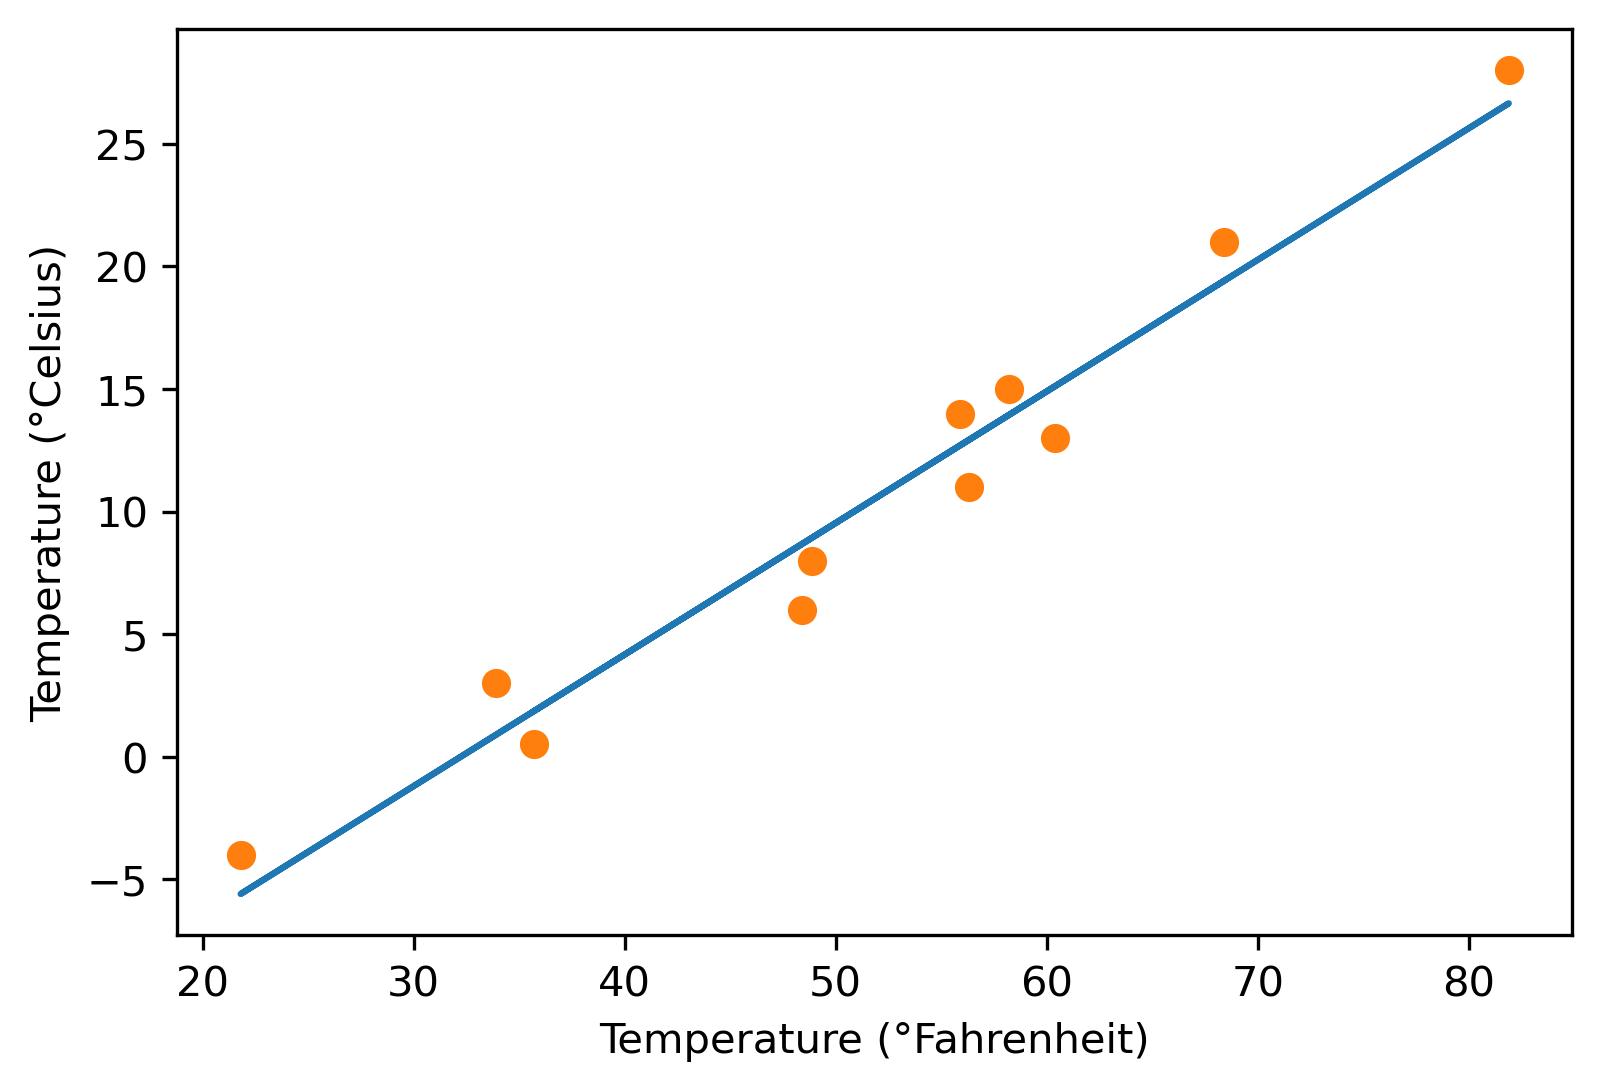

In [27]:
# 7. 进行可视化数据
%matplotlib inline 
params = torch.tensor([  5.3671, -17.3012]) #采用训练之后的数据
from matplotlib import pyplot as plt
t_p = model(t_un, *params)  # 进行一次权重计算
fig = plt.figure(dpi=300) 
plt.xlabel("Temperature (°Fahrenheit)") 
plt.ylabel("Temperature (°Celsius)") 
#绘制一条曲线，X轴数据是t_u（转换为NumPy数组），Y轴数据是t_p（转换为NumPy数组）。
#t_p.detach().numpy()将PyTorch张量t_p从计算图中分离并转换为NumPy数组，以便用于绘图。
plt.plot(t_u.numpy(), t_p.detach().numpy()) 

#绘制散点图，X轴数据是t_u（转换为NumPy数组），Y轴数据是t_c（转换为NumPy数组）。
#'o'表示使用圆圈作为标记。
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

**上面已经完成了一次线性模型的训练**，其中我们是自己手写了 求导、梯度下降和反向传播、输入归一化处理、模型更新、等内容。
其实，pytorch已经为我们提供了反向传播的接口了，我们可以利用pytorch为我们做这部分工作。

In [28]:
def model(t_u, w, b): 
    return w * t_u + b 

def loss_fn(t_p, t_c): 
    squared_diffs = (t_p - t_c)**2 
    return squared_diffs.mean() 

params = torch.tensor([1.0, 0.0], requires_grad=True)
params.grad is None 

loss = loss_fn(model(t_u,*params), t_c)
loss.backward()
print(params.grad)


tensor([4517.2969,   82.6000])


In [51]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c): 
    for epoch in range(1,n_epochs+1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p = model(t_u,*params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
#在这个上下文中，所有的操作都不会被 PyTorch 的自动微分引擎跟踪，因此不会计算或存储梯度。
#这通常用于模型推理或手动更新参数时，避免不必要的梯度计算和内存消耗
#         with torch.no_grad():
#             params = params - learning_rate * params.grad  不能使用这种写法，这种写法会再开辟一个变量，并且导致梯度失败

        with torch.no_grad(): 
            params -= learning_rate * params.grad # 在本地修改
 
        if epoch % 500 == 0: 
            print('Epoch %d, Loss %f' % (epoch, float(loss))) 
 
    return params 

In [52]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

**优化器** 上面我们相当于自己写了一个梯度下降的优化器，接下来我们将用pytorch的优化器来更新参数。根据下图一个模型优化过程是四个步骤：
1. 定义模型
2. 模型计算损失
3. 损失进行backword
4. 优化器根据backword 更新参数 params


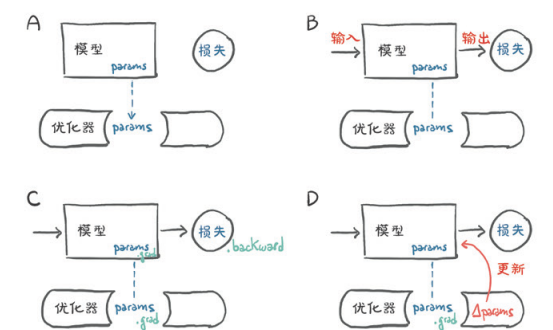

In [55]:
import torch.optim as optim 
params = torch.tensor([1.0, 0.0], requires_grad=True) 
learning_rate = 1e-5 
optimizer = optim.SGD([params],lr=learning_rate) # 优化器输入是参数和学习率

# 利用优化器进行一次计算
t_p = model(t_u, *params) 
loss = loss_fn(t_p, t_c) 
loss.backward()
optimizer.step() 
print(params )

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)


In [60]:
def training_loop(n_epochs, optimizer, params, t_u, t_c): 
    for epochs in range(1,n_epochs+1):
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  # 会自动更新params
        
        if(epochs % 500) == 0:
            print("epochs %d,loss: %f" %(epochs,loss))
        
    return params        

In [68]:
learning_rate = 1e-2
params = torch.tensor([1.0, 0.0], requires_grad=True)

#optimizer = optim.Adam([params],lr=learning_rate)
optimizer = optim.SGD([params],lr=learning_rate)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

epochs 500,loss: 7.860115
epochs 1000,loss: 3.828538
epochs 1500,loss: 3.092191
epochs 2000,loss: 2.957698
epochs 2500,loss: 2.933134
epochs 3000,loss: 2.928648
epochs 3500,loss: 2.927830
epochs 4000,loss: 2.927679
epochs 4500,loss: 2.927652
epochs 5000,loss: 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

 **数据集和验证集：** 下面我们将继续讨论对于已有数据拆分为数据集和验证集来处理方式

In [69]:
n_samples = t_u.shape[0] #11
n_val = int(0.2 * n_samples) # 20%
shuffled_indices = torch.randperm(n_samples) # randperm() 重新排列
train_indices = shuffled_indices[:-n_val] 
val_indices = shuffled_indices[-n_val:] 
print(train_indices,val_indices)

tensor([ 0,  9, 10,  8,  1,  5,  7,  3,  6]) tensor([4, 2])


In [70]:
train_t_u = t_u[train_indices] 
train_t_c = t_c[train_indices] 

val_t_u = t_u[val_indices] 
val_t_c = t_c[val_indices] 
train_t_un = 0.1 * train_t_u 
val_t_un = 0.1 * val_t_u 



In [72]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, 
                  train_t_c, val_t_c): 
    for epoch in range(1, n_epochs + 1): 
        train_t_p = model(train_t_u, *params)  
        train_loss = loss_fn(train_t_p, train_t_c) 
        
        with torch.no_grad(): 
            val_t_p = model(val_t_u, *params) # 这里会记录计算图？->利用torch.no_grad() 来消除影响
            val_loss = loss_fn(val_t_p, val_t_c) 
            assert val_loss.requires_grad == False 
        
        optimizer.zero_grad() 
        train_loss.backward() 
        optimizer.step() 
        
        if(epochs % 500) == 0:
            print("epochs %d,loss: %f" %(epochs,loss))
    return params 